In [ ]:
import os
from glob import glob
import random
from pathlib import Path
import pickle
from functools import partial
import numpy as np
import yaml

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme();
from IPython.display import clear_output
from celluloid import Camera

from sage.training.trainer import MRITrainer
from sage.visualization.vistool import plot_vismap
from sage.visualization.utils import check_type
from sage.config import load_config
from utils.analysis import (
    Result, FileSelector, 
    group_stats, cherry_picker, check_existence, save2nifti, MAE, transform
)

In [ ]:
AVG = np.load("./data/average.npy")
naive_sel = FileSelector("naive")
gt_result = np.array(naive_sel.test_gt)
epoch_parser = lambda path: int(path.split("/layer0/ep")[-1].split("_mae")[0])
mae_parser = lambda path: float(path.split("_mae")[-1].split(".npy")[0])

In [ ]:
with open("./data/naive_reg_test_100.pkl", "rb") as f:
    naive_results = pickle.load(f)
    naive_results = {e[0]: e[1] for e in sorted(naive_results.items(), key=lambda x: x[0])}
    
with open("./data/augment_reg_test_100.pkl", "rb") as f:
    augment_results = pickle.load(f)
    augment_results = {e[0]: e[1] for e in sorted(augment_results.items(), key=lambda x: x[0])}

In [ ]:
with open("./data/naive_nonreg_test_100.pkl", "rb") as f:
    naive_nonreg_results = pickle.load(f)
    naive_nonreg_results = {e[0]: e[1] for e in sorted(naive_nonreg_results.items(), key=lambda x: x[0])}
    
with open("./data/augment_nonreg_test_100.pkl", "rb") as f:
    augment_nonreg_results = pickle.load(f)
    augment_nonreg_results = {e[0]: e[1] for e in sorted(augment_nonreg_results.items(), key=lambda x: x[0])}

In [ ]:
naive = Result(naive_results)
augment = Result(augment_results)

naive_nonreg = Result(naive_nonreg_results)
augment_nonreg = Result(augment_nonreg_results)

In [ ]:
last_values_naive = [e[-1][1] for e in naive.raw_data.values()]
last_values_augment = [e[-1][1] for e in augment.raw_data.values()]

best_values_naive = [min(_[1] for _ in e) for e in naive.raw_data.values()]
best_values_augment = [min(_[1] for _ in e) for e in augment.raw_data.values()]

earlystopped_values_naive = [e[-20][1] for e in naive.raw_data.values()]
earlystopped_values_augment = [e[-20][1] for e in augment.raw_data.values()]

total_train_naive = [len(e) for e in naive.raw_data.values()]
total_train_augment = [len(e) for e in augment.raw_data.values()]

best_indices_naive = [sorted(e, key=lambda x: x[1])[0][0] for e in naive.raw_data.values()]
best_indices_augment = [sorted(e, key=lambda x: x[1])[0][0] for e in augment.raw_data.values()]

In [ ]:
last_values_naive_nonreg = [e[-1][1] for e in naive_nonreg.raw_data.values()]
last_values_augment_nonreg = [e[-1][1] for e in augment_nonreg.raw_data.values()]

best_values_naive_nonreg = [min(_[1] for _ in e) for e in naive_nonreg.raw_data.values()]
best_values_augment_nonreg = [min(_[1] for _ in e) for e in augment_nonreg.raw_data.values()]

earlystopped_values_naive_nonreg = [e[-20][1] for e in naive_nonreg.raw_data.values()]
earlystopped_values_augment_nonreg = [e[-20][1] for e in augment_nonreg.raw_data.values()]

total_train_naive_nonreg = [len(e) for e in naive_nonreg.raw_data.values()]
total_train_augment_nonreg = [len(e) for e in augment_nonreg.raw_data.values()]

best_indices_naive_nonreg = [sorted(e, key=lambda x: x[1])[0][0] for e in naive_nonreg.raw_data.values()]
best_indices_augment_nonreg = [sorted(e, key=lambda x: x[1])[0][0] for e in augment_nonreg.raw_data.values()]

## Make checkpoints

for first 3 epoch, 50 / 30~40 / 20 / 10-

In [ ]:
pct = .9
percentage_indices = {
    "naive": [min(round(e * pct), e-1) for e in total_train_naive],
    "augment": [min(round(e * pct), e-1) for e in total_train_augment],
    "naive_nonreg": [min(round(e * pct), e-1) for e in total_train_naive_nonreg],
    "augment_nonreg": [min(round(e * pct), e-1) for e in total_train_augment_nonreg],
}

0, 1, 2

54.564, 45.84, 23.27, 

8 7.5 6.5 6.0 best

In [270]:
from skimage.filters import gaussian

def mean(lst):

    try: 
        return sum(lst) / len(lst)
    except:
        return sum([_[0] for _ in lst]) / len([_[0] for _ in lst])

def find_first_reached(ckpts, point):

    """
    ckpts: list of tuples [(0, MAE0), (1, MAE1), ...]
    point: float
        when the given checkpoint reached the given point for the first time.
    """
    candidate_prev, candidate_next = None, None
    for epoch, mae in ckpts:

        if mae > point:
            candidate_prev = (epoch, mae)
        else:
            candidate_next = (epoch, mae)
            break

    if candidate_prev is None:
        # Every MAE is smaller than the given point
        return (0, -1)
    elif candidate_next is None:
        # Every MAE is larger than 
        return (len(ckpts), -1)
    elif candidate_prev is None and candidate_next is None:
        print("Something is wrong...")
        return None

    if (candidate_prev[1] - point) >= (point - candidate_next[1]):
        return candidate_next
    else:
        return candidate_prev

def first_reached_indices(config, point):

    raw_data = {
        "naive": naive.raw_data.values(),
        "augment": augment.raw_data.values(),
        "naive_nonreg": naive_nonreg.raw_data.values(),
        "augment_nonreg": augment_nonreg.raw_data.values(),
    }
    indices = [find_first_reached(ckpts, point) for ckpts in raw_data[config]]
    return [_[0] for _ in indices], mean(list(filter(lambda x: x[1] != -1, indices)))

def first_reached_maes(config, point):

    raw_data = {
        "naive": naive.raw_data.values(),
        "augment": augment.raw_data.values(),
        "naive_nonreg": naive_nonreg.raw_data.values(),
        "augment_nonreg": augment_nonreg.raw_data.values(),
    }
    maes = [find_first_reached(ckpts, point)[1] for ckpts in raw_data[config]]
    return list(filter(lambda x: x != -1, maes)), mean(list(filter(lambda x: x != -1, maes)))

In [271]:
best_indices = {
    "naive": best_indices_naive,
    "augment": best_indices_augment,
    "naive_nonreg": best_indices_naive_nonreg,
    "augment_nonreg": best_indices_augment_nonreg,
}

def make_maeckpt_maps(config, point):


    """
    config <str>:
        use one of naive, naive_nonreg, augment, augment_nonreg
    """
    selector = FileSelector(config)
    _cherry_picker = partial(cherry_picker, selector=selector)
    _check_existence = partial(check_existence, selector=selector)

    _indices, mean_indices = first_reached_indices(config, point)
    _, mean_mae = first_reached_maes(config, point)
    print(f"Make {config} Point {point}. Selected {len(_)} maps. Average Epoch {mean_indices} | Average MAE {mean_mae}.")

    filtered = list(filter(
        _check_existence,
        zip(range(len(_indices)), _indices)
    ))
    best_map = np.array(list(map(
        _cherry_picker,
        filtered
    )))
    return best_map, len(_)

def make_soft_thresholded_map(best_map, quantile, plot=True, masked=False):

    thresholded = np.array([
        (np.abs(npy) > np.quantile(np.abs(npy), quantile)) for npy in best_map
    ]) * best_map
    if plot:
        # plot_vismap(AVG, np.mean(thresholded, axis=0), masked=masked);
        plot_vismap(AVG, gaussian(np.mean(thresholded, axis=0)), masked=masked);
    return thresholded

def make_selected_epoch_maps(config, epoch):

    selector = FileSelector(config)
    _cherry_picker = partial(cherry_picker, selector=selector)
    _check_existence = partial(check_existence, selector=selector)

    _indices = [epoch] * 100
    filtered = list(filter(
        _check_existence,
        zip(range(len(_indices)), _indices)
    ))
    print(f"Total {len(filtered)} seeds were able to be chosen.")
    best_map = np.array(list(map(
        _cherry_picker,
        filtered
    )))
    return best_map

def count_nonzero_voxels(thrsh):
    return (thrsh != 0).sum()
    
def exp_quantile_agree(maps_agg, quantile, agree_threshold, plot=True):

    print(f"Quantile: {quantile:.2f} | Agree Threhsold: {agree_threshold}")

    bool_brain = np.array([
        (np.abs(npy) > np.quantile(np.abs(npy), quantile)) for npy in maps_agg
    ])
    agreement = bool_brain.sum(axis=0) > agree_threshold
    thresholded = (maps_agg * agreement).sum(axis=0)
    print(f"Nonzero Voxels: {count_nonzero_voxels(thresholded)}")
    if plot:
        plot_vismap(AVG, thresholded, masked=False);
    return thresholded

In [240]:
quantile = 0.99

In [275]:
interval = 5.945609915223842 - 5.656725651858605
interval

0.28888426336523665

In [281]:
first_reached_maes("naive", start)[1]

8.518675785195338

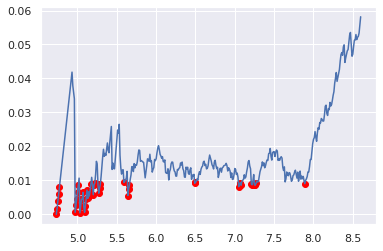

In [335]:
start = 8.611866127693489
end = 4.733679967383816

x = []
y = []

x_min = []
y_min = []

while True:

    start -= 0.01

    point = start
    try:
        naive_error = first_reached_maes("naive", start)[1]
        naive_error = abs(point - naive_error)/naive_error
    except ZeroDivisionError:
        naive_error = 0

    try:
        augment_error = first_reached_maes("augment", start)[1]
        augment_error = abs(point - augment_error)/augment_error
    except:
        augment_error = 0

    err = naive_error + augment_error

    x.append(point)
    y.append(err)

    if err < 0.0095:
        x_min.append(point)
        y_min.append(err)

    if point < end:
        break

plt.plot(x, y)
plt.scatter(x_min, y_min, color="red")

In [354]:
ckpt

[7.891866127693504,
 7.243866127693518,
 6.496866127693534,
 5.636866127693552,
 5.27686612769356,
 5.096449461026896,
 4.751866127693571]

In [339]:
list(filter(lambda x: 5.5 > x > 4.78, x_min))

[5.2918661276935595,
 5.28186612769356,
 5.27186612769356,
 5.26186612769356,
 5.221866127693561,
 5.211866127693561,
 5.201866127693561,
 5.191866127693562,
 5.171866127693562,
 5.161866127693562,
 5.1518661276935624,
 5.141866127693563,
 5.131866127693563,
 5.121866127693563,
 5.111866127693563,
 5.1018661276935635,
 5.091866127693564,
 5.081866127693564,
 5.071866127693564,
 5.061866127693564,
 5.051866127693565,
 5.041866127693565,
 5.031866127693565,
 5.011866127693565,
 5.001866127693566,
 4.991866127693566,
 4.981866127693566,
 4.971866127693566]

In [346]:
ckpt = [None for _ in range(7)]

ckpt[0] = [7.891866127693504,]
ckpt[1] = [7.271866127693517,
 7.2618661276935175,
 7.251866127693518,
 7.221866127693518,
 7.2118661276935185,]
ckpt[2] = [6.501866127693534,
 6.491866127693534,]
ckpt[3] = [ 5.661866127693552,
 5.651866127693552,
 5.641866127693552,
 5.591866127693553,]

ckpt[4] = [5.2918661276935595,
 5.28186612769356,
 5.27186612769356,
 5.26186612769356,]

ckpt[5] = [5.221866127693561,
 5.211866127693561,
 5.201866127693561,
 5.191866127693562,
 5.171866127693562,
 5.161866127693562,
 5.1518661276935624,
 5.141866127693563,
 5.131866127693563,
 5.121866127693563,
 5.111866127693563,
 5.1018661276935635,
 5.091866127693564,
 5.081866127693564,
 5.071866127693564,
 5.061866127693564,
 5.051866127693565,
 5.041866127693565,
 5.031866127693565,
 5.011866127693565,
 5.001866127693566,
 4.991866127693566,
 4.981866127693566,
 4.971866127693566]

ckpt[6] = [4.7718661276935705,
 4.761866127693571,
 4.751866127693571,
 4.741866127693571,
 4.731866127693571]

ckpt = [mean(_ckpt) for _ckpt in ckpt]

In [329]:
min(best_values_augment), min(best_values_naive), max(best_values_augment), max(best_values_naive)

(4.733679967383816, 5.228786886554875, 6.400294708879026, 6.734645948018113)

In [263]:
start = (10.330042054947107 + 8.611866127693489) / 2
end =  (5.945609915223842 + 5.656725651858605) / 2

print(start, end)
[start - (start - end) * ((i+1) / 10) for i in range(10)]

9.470954091320298 5.801167783541223


[9.10397546054239,
 8.736996829764482,
 8.370018198986575,
 8.003039568208667,
 7.636060937430761,
 7.269082306652853,
 6.902103675874946,
 6.535125045097038,
 6.16814641431913,
 5.801167783541223]

Make augment Point 5.656725651858605. Selected 52 maps. Average Epoch 45.94230769230769 | Average MAE 5.632824153618769.
0 39
4 52
5 40
8 93
10 29
12 44
14 66
17 44
18 46
19 60
20 49
24 57
27 53
28 109
29 53
30 50
33 150
34 84
36 41
37 100
38 55
41 59
44 35
46 74
47 66
48 52
53 60
55 49
56 89
57 74
59 78
61 59
65 54
66 43
67 45
70 52
71 53
72 35
73 62
79 60
80 43
81 47
84 61
88 82
89 62
92 68
93 68
96 42


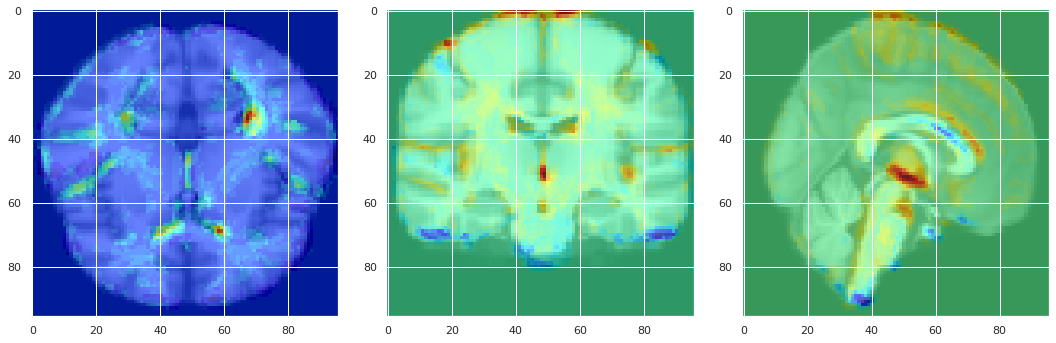

In [265]:
point = 5.656725651858605
# naive_cut = make_maeckpt_maps("naive", point)
# make_soft_thresholded_map(naive_cut, quantile);

augment_cut, num_maps = make_maeckpt_maps("augment", point)
make_soft_thresholded_map(augment_cut, quantile);

Make naive Point 7.891866127693504. Selected 100 maps. Average Epoch 4.04 | Average MAE 7.823679864635207.


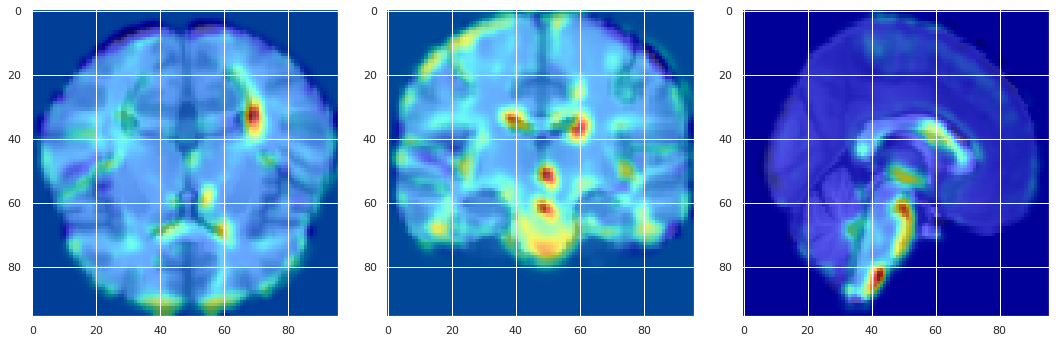

Make augment Point 7.891866127693504. Selected 100 maps. Average Epoch 6.49 | Average MAE 7.889359608088455.


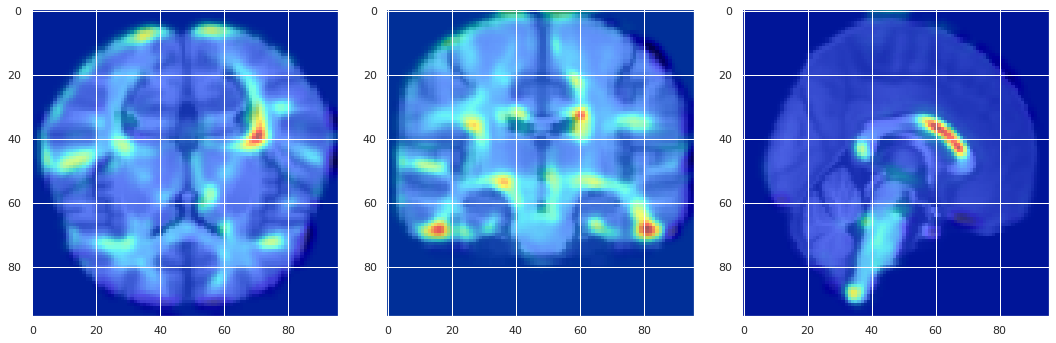

******************************
Make naive Point 7.243866127693518. Selected 100 maps. Average Epoch 6.29 | Average MAE 7.199773776041317.


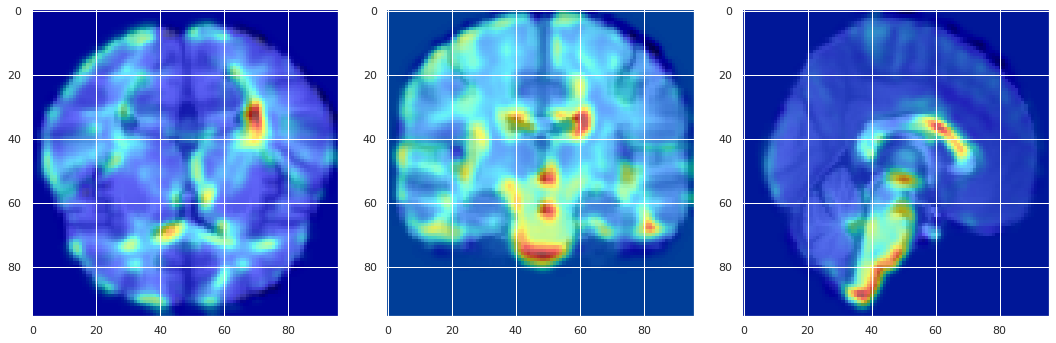

Make augment Point 7.243866127693518. Selected 100 maps. Average Epoch 10.81 | Average MAE 7.204547663257548.


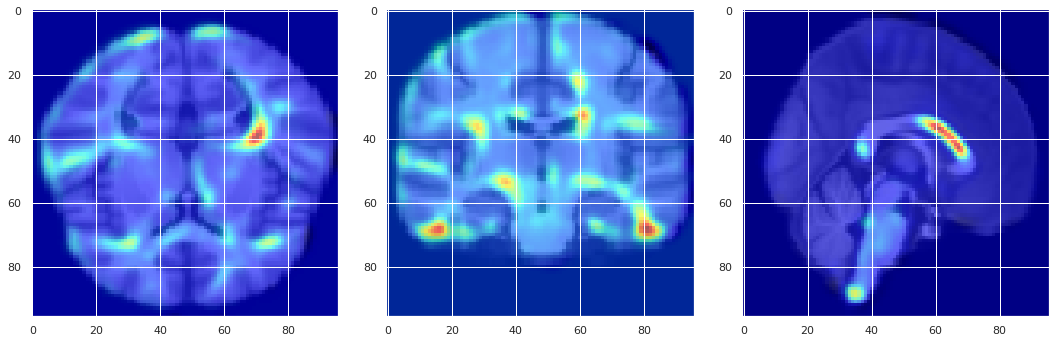

******************************
Make naive Point 6.496866127693534. Selected 91 maps. Average Epoch 18.582417582417584 | Average MAE 6.454384949486175.
13 32
24 35
27 49
43 37
56 31
58 29
67 28
71 34
82 49


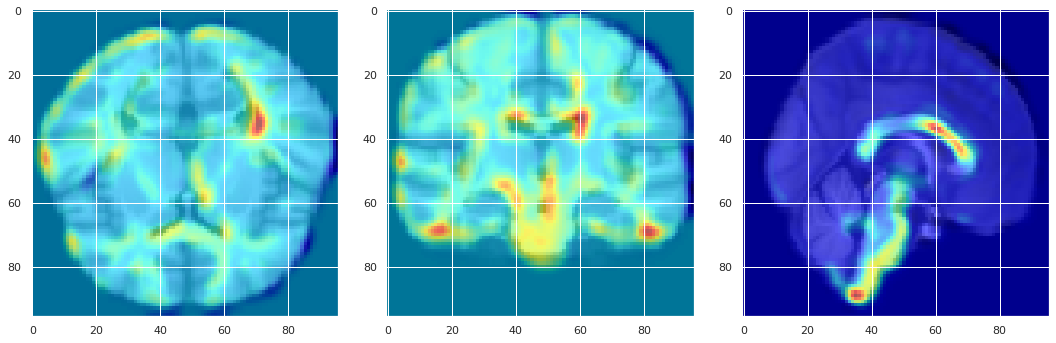

Make augment Point 6.496866127693534. Selected 100 maps. Average Epoch 23.58 | Average MAE 6.482215228799274.


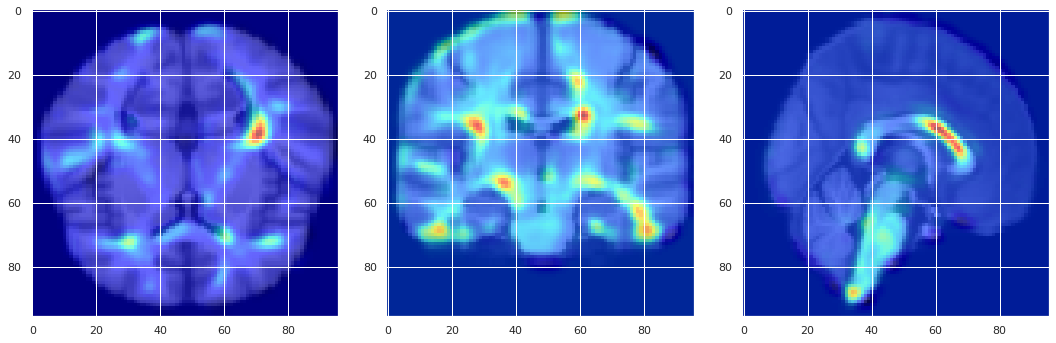

******************************
Make naive Point 5.636866127693552. Selected 23 maps. Average Epoch 44.91304347826087 | Average MAE 5.622185064114723.
0 97
3 44
5 38
6 49
8 42
10 63
11 37
13 32
14 42
15 47
17 47
18 66
19 34
20 65
23 43
24 35
25 34
26 45
27 49
29 34
30 33
31 30
32 43
37 72
38 93
40 37
41 48
42 27
43 37
44 40
46 45
47 45
48 73
50 86
51 34
52 51
54 48
55 80
56 31
57 65
58 29
59 65
60 37
61 82
62 51
63 120
65 58
66 39
67 28
68 43
69 62
70 50
71 34
72 98
73 62
74 104
75 63
77 50
78 59
79 32
80 38
81 48
82 49
85 60
86 50
87 54
89 60
90 51
91 39
92 72
93 41
94 48
95 53
96 58
97 52
98 69
99 60


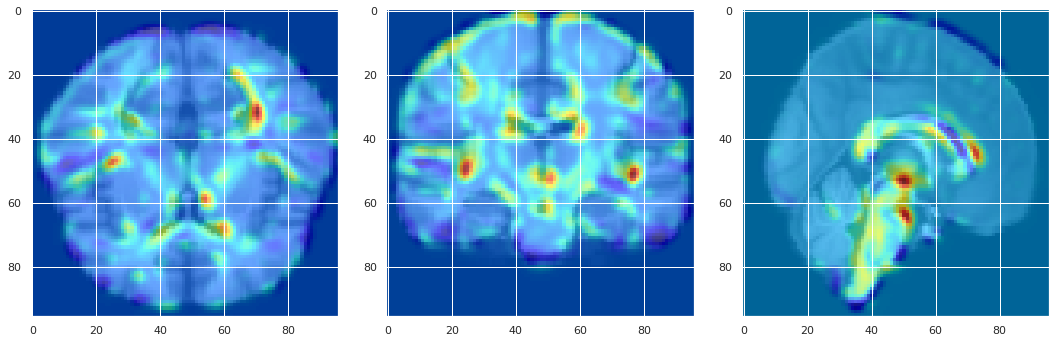

Make augment Point 5.636866127693552. Selected 50 maps. Average Epoch 45.62 | Average MAE 5.605509085720534.
0 39
4 52
5 40
8 93
10 29
12 44
14 66
17 44
18 46
19 60
20 49
24 57
27 53
28 109
29 53
30 50
33 150
34 84
36 41
37 100
38 55
41 59
44 35
46 74
47 66
48 52
51 83
53 60
55 49
56 89
57 74
59 78
61 59
65 54
66 43
67 45
70 52
71 53
72 35
73 62
76 77
79 60
80 43
81 47
84 61
88 82
89 62
92 68
93 68
96 42


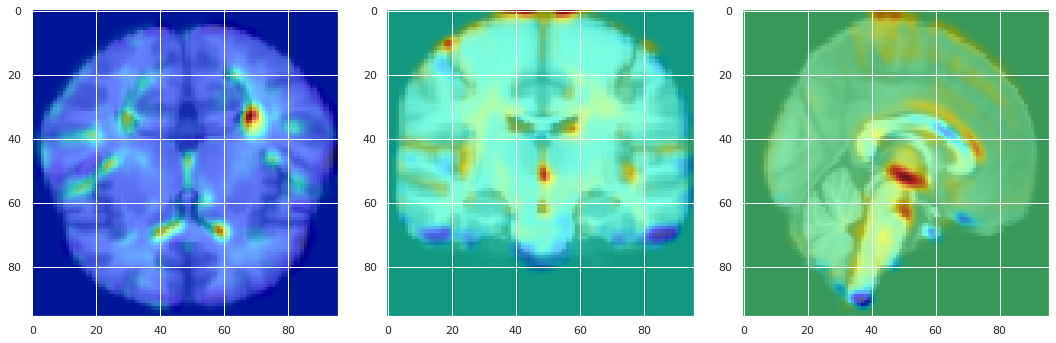

******************************
Make naive Point 5.27686612769356. Selected 1 maps. Average Epoch 28.0 | Average MAE 5.26208352389401.
0 97
1 62
2 104
3 44
4 73
5 38
6 49
7 72
8 42
9 55
10 63
11 37
12 67
13 32
14 42
15 47
16 86
17 47
18 66
19 34
20 65
21 69
22 64
23 43
24 35
25 34
26 45
27 49
28 51
29 34
30 33
31 30
32 43
33 70
34 79
35 47
36 39
37 72
38 93
40 37
41 48
42 27
43 37
44 40
45 47
46 45
47 45
48 73
49 74
50 86
51 34
52 51
53 62
54 48
55 80
56 31
57 65
58 29
59 65
60 37
61 82
62 51
63 120
64 55
65 58
66 39
67 28
68 43
69 62
70 50
71 34
72 98
73 62
74 104
75 63
76 49
77 50
78 59
79 32
80 38
81 48
82 49
83 78
84 108
85 60
86 50
87 54
88 58
89 60
90 51
91 39
92 72
93 41
94 48
95 53
96 58
97 52
98 69
99 60


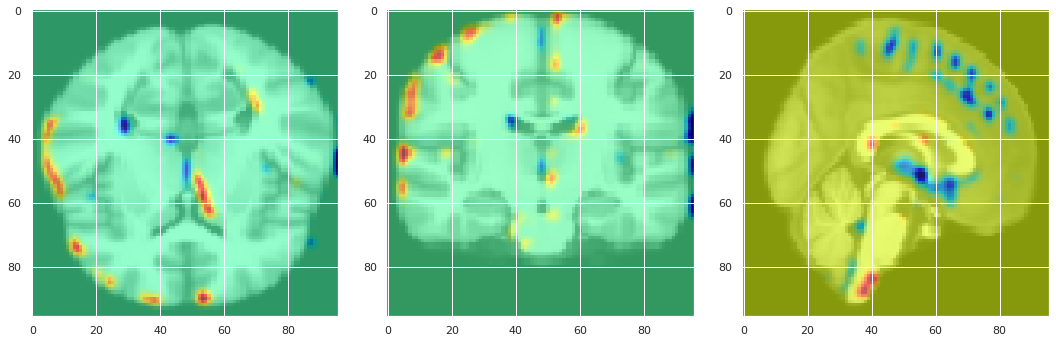

Make augment Point 5.27686612769356. Selected 10 maps. Average Epoch 60.1 | Average MAE 5.252314562340305.
0 39
1 74
2 85
3 54
4 52
5 40
6 64
7 63
8 93
10 29
11 53
12 44
14 66
16 78
17 44
18 46
19 60
20 49
21 85
22 65
23 91
24 57
25 61
27 53
28 109
29 53
30 50
31 67
32 81
33 150
34 84
36 41
37 100
38 55
39 57
40 94
41 59
42 69
43 68
44 35
45 78
46 74
47 66
48 52
49 84
50 98
51 83
53 60
54 60
55 49
56 89
57 74
58 74
59 78
60 74
61 59
62 93
63 88
64 59
65 54
66 43
67 45
68 46
69 101
70 52
71 53
72 35
73 62
74 39
75 97
76 77
77 44
78 72
79 60
80 43
81 47
82 83
83 71
84 61
86 110
87 110
88 82
89 62
92 68
93 68
94 96
95 67
96 42
97 57
98 59


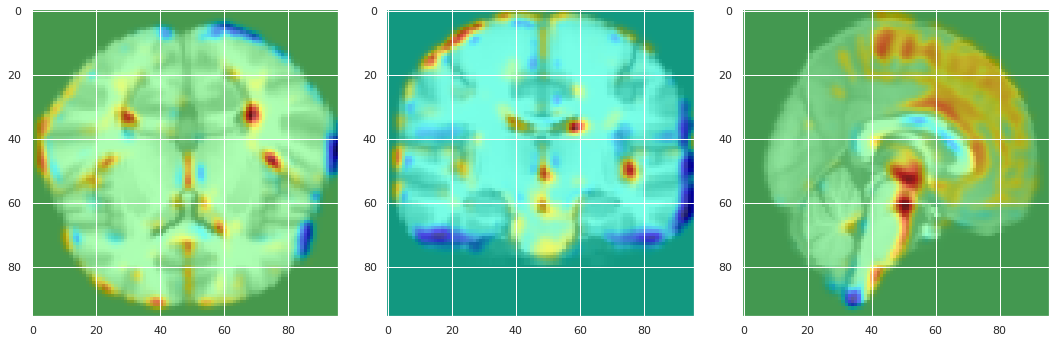

******************************
Make augment Point 5.096449461026896. Selected 4 maps. Average Epoch 79.0 | Average MAE 5.088632799174688.
0 39
1 74
2 85
3 54
4 52
5 40
6 64
7 63
8 93
10 29
11 53
12 44
13 73
14 66
15 130
16 78
17 44
18 46
19 60
20 49
21 85
22 65
23 91
24 57
25 61
27 53
28 109
29 53
30 50
31 67
32 81
33 150
34 84
35 92
36 41
37 100
38 55
39 57
40 94
41 59
42 69
43 68
44 35
45 78
46 74
47 66
48 52
49 84
50 98
51 83
52 51
53 60
54 60
55 49
56 89
57 74
58 74
59 78
60 74
61 59
62 93
63 88
64 59
65 54
66 43
67 45
68 46
69 101
70 52
71 53
72 35
73 62
74 39
75 97
76 77
77 44
78 72
79 60
80 43
81 47
82 83
83 71
84 61
85 53
86 110
87 110
88 82
89 62
92 68
93 68
94 96
95 67
96 42
97 57
98 59
99 65


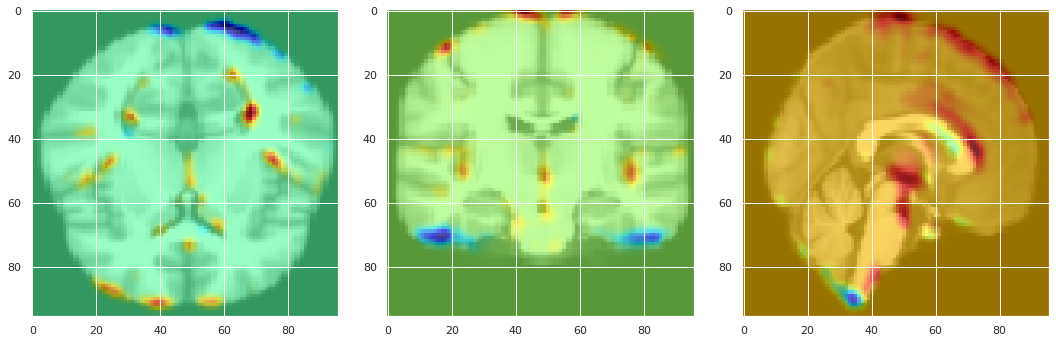

Make augment Point 4.751866127693571. Selected 1 maps. Average Epoch 100.0 | Average MAE 4.733679967383816.
0 39
1 74
2 85
3 54
4 52
5 40
6 64
7 63
8 93
9 89
10 29
11 53
12 44
13 73
14 66
15 130
16 78
17 44
18 46
19 60
20 49
21 85
22 65
23 91
24 57
25 61
26 112
27 53
28 109
29 53
30 50
31 67
32 81
33 150
34 84
35 92
36 41
37 100
38 55
39 57
40 94
41 59
42 69
43 68
44 35
45 78
46 74
47 66
48 52
49 84
50 98
51 83
52 51
53 60
54 60
55 49
56 89
57 74
58 74
59 78
60 74
61 59
62 93
63 88
64 59
65 54
66 43
67 45
68 46
69 101
70 52
71 53
72 35
73 62
74 39
75 97
76 77
77 44
78 72
79 60
80 43
81 47
82 83
83 71
84 61
85 53
86 110
87 110
88 82
89 62
90 73
92 68
93 68
94 96
95 67
96 42
97 57
98 59
99 65


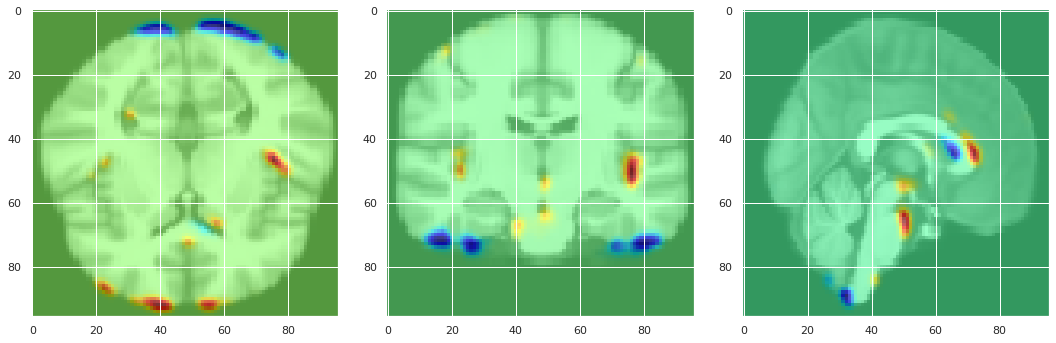

In [353]:
# for point in [53, 45, 23, 8, 7.5, 7, 6.5, 6, 5.5]:
# for point in [53, 45, 23] + [start - (start - end) * ((i+1) / 10) for i in range(10)]:
# for point in [start - (start - end) * ((i+1) / 10) for i in range(10)]:
for point in ckpt[:-2]:

    naive_cut, num_maps = make_maeckpt_maps("naive", point)
    make_soft_thresholded_map(naive_cut, quantile);
    # exp_quantile_agree(naive_cut, .9, round(num_maps / 2));

    augment_cut, num_maps = make_maeckpt_maps("augment", point)
    make_soft_thresholded_map(augment_cut, quantile);
    # exp_quantile_agree(augment_cut, .9, round(num_maps / 2));
    print(f"{'*' *  30}")

for point in ckpt[-2:]:
    augment_cut, num_maps = make_maeckpt_maps("augment", point)
    make_soft_thresholded_map(augment_cut, quantile);

In [351]:
ckpt[-2]

5.096449461026896